# Benchmarking Apache CPP-Parquet
## Neelaksh Singh and Corwin Joy 

### MLH project in collaboration with G-Research to benchmark Apache CPP-Parquet performance 

This repository contains reproducible code for benchmarking Apache Parquet on multiple dimensions, in order to get an idea of the performance of Parquet for machine learning workloads.

The motivation is to make parquet files with many thousands of columns efficient to read. 

Currently, reading such files is prohibitively expensive because fetching and parsing the metadata takes considerable time. The current serialization scheme for parquet metadata is too slow to be parsed efficiently.


Thus, we quantify the metadata overhead of Apache Parquet files for storing thousands of columns, as well as space and decode time for the page data using Apache CPP-Parquet.

#### Motivation

Many recent claims suggest that Parquet is unsuitable for wide tables with thousands of columns, which are common in machine learning workloads. These claims often come alongside proposals for new file formats (such as BtrBlocks, Lance V2, and Nimble1).

The main argument is that wide tables have "large" metadata, which reportedly takes a "long time" to decode, often longer than reading the actual data. The use of Apache Thrift for metadata storage means the entire metadata must be decoded for each file, even when only a few columns are needed. There's also a tendency to conflate Parquet (the format) with specific Parquet implementations (e.g., parquet-java) when assessing performance.

While many query systems cache Parquet metadata information in a form suited for faster processing, we sought quantitative data to determine how much of the supposed metadata overhead is due to limitations in the Parquet format vs. how much is due to less optimized implementations or poorly configured settings of Parquet writers.

## Setting up the Project

To set up the project and build the necessary C++ files for benchmarking Parquet, we have a `setup.sh` script that automates the following steps:

1. Download the vcpkg repository from GitHub.
2. Install Apache Arrow and Parquet using vcpkg.
3. Configure the project using CMake.
4. Build the project.

Follow these steps to make the script executable and run it:

In [ ]:
import os

# Make the setup.sh script executable
os.chmod("./setup.sh", 0o755)

# Run the setup.sh script
os.system("./setup.sh")

# Set the working directory
os.chdir("./temp")

Here's a breakdown of what the `setup.sh` script does:

1. **Download vcpkg**: The script clones the vcpkg repository from GitHub. vcpkg is a cross-platform package manager that simplifies the process of installing and managing C++ libraries.

2. **Install Apache Arrow and Parquet**: Using vcpkg, the script installs the Apache Arrow and Parquet libraries. These libraries provide the necessary tools and APIs for working with Parquet files in C++.

3. **Configure the project with CMake**: The script uses CMake to configure the project. CMake is a build system generator that helps manage the build process of the project. It generates the necessary build files based on the project's configuration.

4. **Build the project**: Finally, the script triggers the build process using the generated build files. This step compiles the C++ source files and links them with the required libraries, creating the executable for benchmarking Parquet.

By running the `setup.sh` script using Python's `os` module, as shown in the code snippet above, the entire setup process is automated. The script takes care of downloading the necessary dependencies, configuring the project, and building it.

After the script completes successfully, your project will be set up and ready for benchmarking Parquet using C++.

*Note*: The files for benchmarking are present in <b>/src</b> and files for visualization is present in <b>/scripts</b>

## Metadata Size and Decode Time

Parquet files include the metadata required to interpret the file. This metadata also instructs the reader to load only the portion of the file necessary to answer queries. 

The metadata is encoded in the Apache Thrift format, which requires Parquet readers to fetch and potentially examine the entire metadata footer before reading any content.

### Code Structure

#### File Structure and Purpose 

We've created three main files for this benchmarking project:

1. `arrow_benchmarks.h`: This header file defines the structure for our benchmark results and declares the functions we'll use for benchmarking and writing results.

2. `arrow_benchmarks.cpp`: This is our main implementation file. It includes the following key components:
   - A function to benchmark metadata decoding time and file size for a given Parquet file
   - A function to write benchmark results to a CSV file
   - A main function that runs benchmarks on Parquet files with varying numbers of columns

3. `visualize_decode_and_size.py`: This Python script visualizes the Parquet files we'll use for benchmarking.

#### Benchmarking Approach

Our approach involves:

1. Generating Parquet files with different numbers of columns (10, 100, 1000, 10000) using apache parquet and the arrow library.
2. Using C++ with the Arrow and Parquet libraries to measure:
   - The time taken to open and decode the metadata of each Parquet file
   - The size of each Parquet file
3. Writing the results to a CSV file for further analysis
4. Visualizing the results

This method allows us to empirically measure how metadata decoding time and file size scale with the number of columns, providing insights into Parquet's performance characteristics for wide tables.

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Create benchmark files
os.system("../build/test_data_generator")

Successfully wrote benchmark_float32_10cols.parquet
Successfully wrote benchmark_float32_100cols.parquet
Successfully wrote benchmark_float32_1000cols.parquet
Successfully wrote benchmark_float32_10000cols.parquet


0

In [13]:
# Run the compiled C++ benchmark program
os.system("../build/arrow_benchmarks")

data = pd.read_csv('benchmark_decode_and_size.csv')
data

,num_columns,decode_time_ms,size_mb
0,10,0.479630,0.551187
1,100,0.857198,5.511790
2,1000,8.102080,55.121200
3,10000,84.819800,551.284000


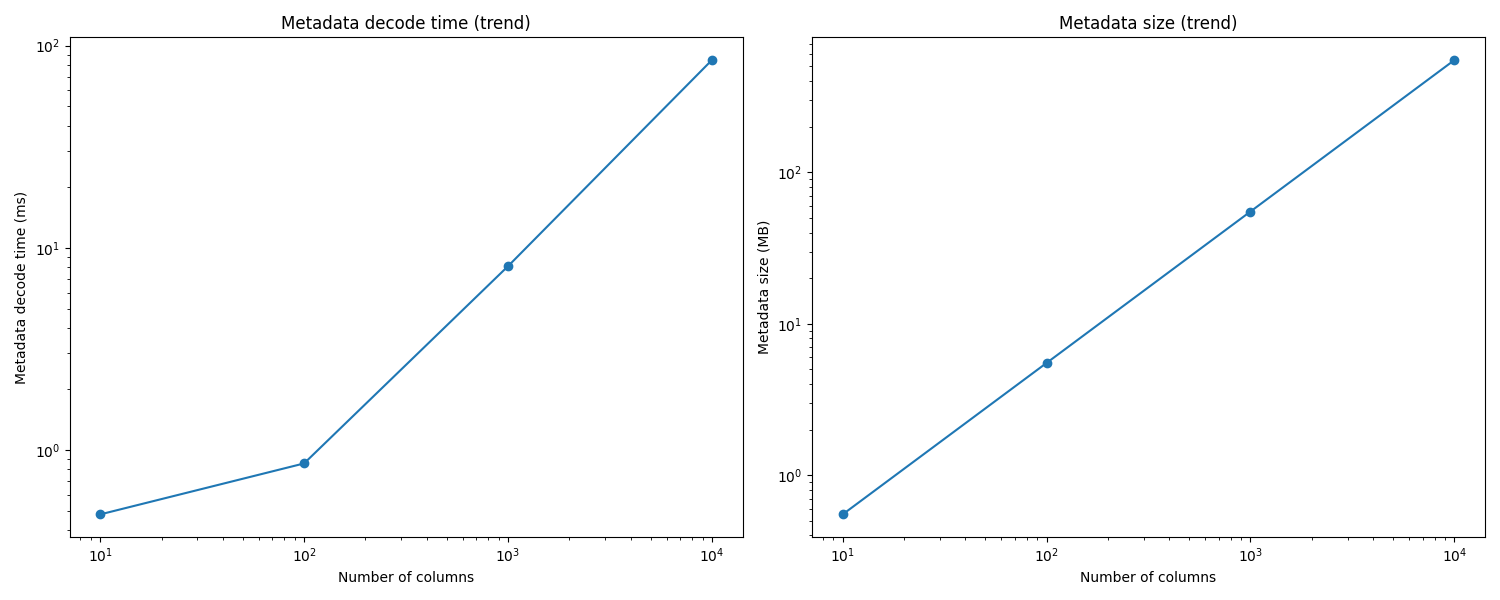

In [14]:
from IPython.display import Image
def plot_benchmarks(data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(data['num_columns'], data['decode_time_ms'], marker='o')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Number of columns')
    ax1.set_ylabel('Metadata decode time (ms)')
    ax1.set_title('Metadata decode time (trend)')

    ax2.plot(data['num_columns'], data['size_mb'], marker='o')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Number of columns')
    ax2.set_ylabel('Metadata size (MB)')
    ax2.set_title('Metadata size (trend)')

    plt.tight_layout()
    plt.savefig('./decode_and_size.png')
    plt.close()
    
plot_benchmarks(data)
Image(filename='./decode_and_size.png')

The plot shows the trends of metadata decode time and metadata size as the number of columns increases. Both the decode time and metadata size exhibit a logarithmic relationship with the number of columns, indicating that they grow sublinearly with the number of columns in the Parquet file.

This benchmark helps us understand how the metadata size and decode time scale with the number of columns in a Parquet file, which can be useful for optimizing Parquet file structures and reader performance.

#### Metadata reads VS Actual Data Reads

In [8]:
# Run the benchmark for data reads
os.system("../build/data_read_benchmark")

Running benchmark for 10 columns...
Running benchmark for 100 columns...
Running benchmark for 1000 columns...
All benchmarks completed successfully. Results saved to CSV files.


0

Plot has been saved as data_read_benchmark.png

Results for 1000.0 columns and 100000.0 rows:
Metadata decode time: 30.63 ms
Full data read time: 3139.43 ms
Random column read time: 1472.24 ms
Page read time: 34.01 ms

Results for 10.0 columns and 100000.0 rows:
Metadata decode time: 1.16 ms
Full data read time: 33.53 ms
Random column read time: 14.35 ms
Page read time: 26.80 ms

Results for 100.0 columns and 100000.0 rows:
Metadata decode time: 3.12 ms
Full data read time: 301.85 ms
Random column read time: 141.85 ms
Page read time: 27.09 ms


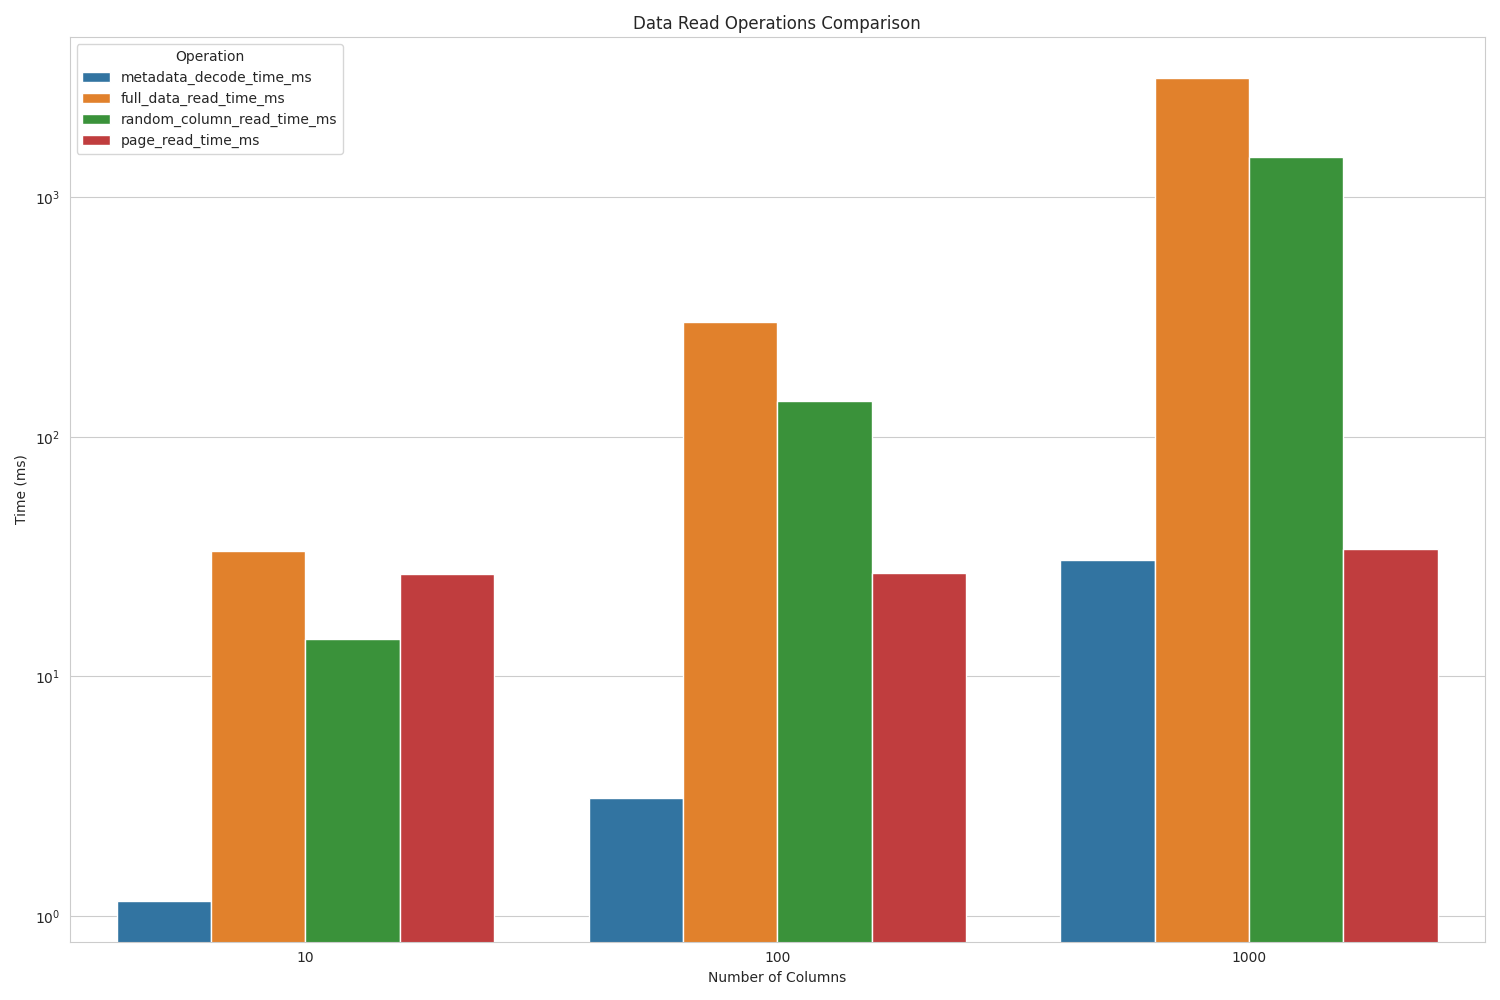

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import glob

# Read all CSV files
csv_files = glob.glob('data_read_benchmark_*_benchmark_results.csv')
dfs = [pd.read_csv(f) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

# Set up the plot style
sns.set_style("whitegrid")

# Melt the dataframe for easier plotting
df_melted = df.melt(id_vars=['num_columns', 'num_rows'], 
                    var_name='operation', 
                    value_name='time_ms')

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(x='num_columns', y='time_ms', hue='operation', data=df_melted)
plt.title('Data Read Operations Comparison')
plt.xlabel('Number of Columns')
plt.ylabel('Time (ms)')
plt.yscale('log')
plt.legend(title='Operation')
plt.tight_layout()
plt.savefig('./data_read_benchmark.png')
plt.close()

print("Plot has been saved as data_read_benchmark.png")

# Print results to console
for _, row in df.iterrows():
    print(f"\nResults for {row['num_columns']} columns and {row['num_rows']} rows:")
    print(f"Metadata decode time: {row['metadata_decode_time_ms']:.2f} ms")
    print(f"Full data read time: {row['full_data_read_time_ms']:.2f} ms")
    print(f"Random column read time: {row['random_column_read_time_ms']:.2f} ms")
    print(f"Page read time: {row['page_read_time_ms']:.2f} ms")

Image(filename='./data_read_benchmark.png')

#### Parquet Data Read Benchmark Summary

This benchmark evaluates Parquet file performance across different data read operations as the number of columns increases. Key observations:

1. **Metadata Decode**: Scales well with column count, remaining efficient even for wide tables.
2. **Full Data Read**: Time increases significantly with more columns, becoming the slowest operation for wide tables.
3. **Random Column Read**: Demonstrates the advantage of Parquet's columnar format, performing better than full reads for wide tables.
4. **Page Read**: Remains consistently fast regardless of column count, showing efficient data chunking.

Overall, the results show that Parquet maintains good performance for selective reads and metadata operations even with many columns. The benchmark emphasizes the importance of query optimization techniques like column pruning and predicate pushdown when working with wide Parquet tables.


## Paging, Chunking and Statistics

### Code Structure

#### File Structure and Purpose

Our benchmarking setup consists of two main files:

1. `metadata_benchmark.h`: This header file defines the structures for our benchmark results and declares the functions used for benchmarking and writing results.

2. `metadata_benchmark.cpp`: This is our main implementation file, containing:
   - Functions to benchmark metadata decoding time and file size
   - Functions to benchmark statistics decoding time
   - A main function that generates test data, runs benchmarks, and writes results

#### Benchmarking Approach

Our approach involves:

1. Generating Parquet files with varying numbers of columns (10, 100, 1000, 10000) and different statistics levels (NONE, CHUNK, PAGE).
2. Measuring:
   - Total metadata decode time
   - Thrift decode time (for file-level metadata)
   - Schema building time
   - Statistics decode time
   - File size
3. Writing results to CSV files for further analysis

#### Key Components

1. `BenchmarkChunksAndPages`: Measures metadata decoding performance.
2. `BenchmarkStats`: Measures statistics decoding performance.
3. `WriteChunksAndPagesResults` and `WriteStatsBenchmarkResults`: Write benchmark results to CSV files.
4. Main function: Orchestrates the benchmark process, including file generation and cleanup.

In [9]:
import os
from IPython.display import Image

# Compile and run the C++ benchmark program
os.system("../build/metadata_benchmark")

0

### Chunks and Paging

In this benchmark, we aim to analyze the impact of chunking, paging, and statistics on the performance of Parquet files. We measure the metadata decode time, metadata size, and decode time breakdown for different configurations of chunking, paging, and statistics levels

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv('benchmark_chunks_and_pages.csv')

# Convert microseconds to milliseconds
time_columns = ['total_decode_time_us', 'thrift_decode_time_us', 'schema_build_time_us']
for col in time_columns:
    df[col.replace('_us', '_ms')] = df[col] / 1000

# Convert bytes to megabytes
df['size_mb'] = df['size_bytes'] / (1024 * 1024)

# Map stats levels to readable labels
stats_map = {0: 'None', 1: 'Chunk', 2: 'Page'}
df['stats_level'] = df['stats_level'].map(stats_map)

df

,num_columns,total_decode_time_us,thrift_decode_time_us,schema_build_time_us,size_bytes,stats_level,total_decode_time_ms,thrift_decode_time_ms,schema_build_time_ms,size_mb
0,10,623.109,555.983,66.996,577133,None,0.623109,0.555983,0.066996,0.550397
1,10,224.781,161.202,63.499,577869,Chunk,0.224781,0.161202,0.063499,0.551099
2,10,184.265,131.727,52.448,577893,Page,0.184265,0.131727,0.052448,0.551122
3,100,900.679,615.113,285.476,5770709,None,0.900679,0.615113,0.285476,5.503377
4,100,945.193,662.272,282.831,5778921,Chunk,0.945193,0.662272,0.282831,5.511209
5,100,926.147,645.040,281.027,5778953,Page,0.926147,0.645040,0.281027,5.511239
6,1000,8146.550,5554.710,2591.740,57711168,None,8.146550,5.554710,2.591740,55.037659
7,1000,13600.200,9177.510,4422.520,57793324,Chunk,13.600200,9.177510,4.422520,55.116009
8,1000,8424.800,5895.050,2529.660,57793240,Page,8.424800,5.895050,2.529660,55.115929
9,10000,88803.900,59028.200,29775.600,577187531,None,88.803900,59.028200,29.775600,550.448924


In [16]:
# Set up the plot style
sns.set_style("whitegrid")

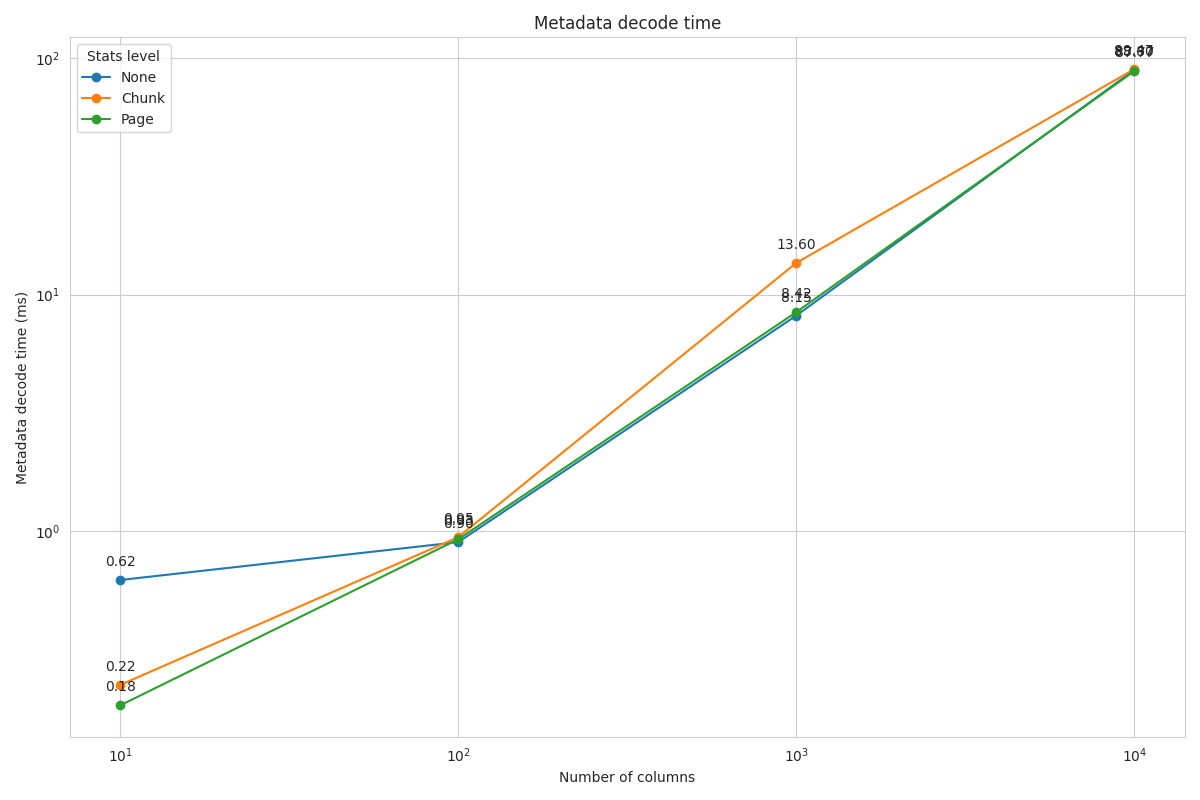

In [17]:
# Plot 1: Metadata decode time
plt.figure(figsize=(12, 8))
for stats in df['stats_level'].unique():
    data = df[df['stats_level'] == stats]
    plt.plot(data['num_columns'], data['total_decode_time_ms'], marker='o', label=stats)
    for i, point in data.iterrows():
        plt.annotate(f"{point['total_decode_time_ms']:.2f}", 
                     (point['num_columns'], point['total_decode_time_ms']),
                     textcoords="offset points", xytext=(0,10), ha='center')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of columns')
plt.ylabel('Metadata decode time (ms)')
plt.title('Metadata decode time')
plt.legend(title='Stats level')
plt.tight_layout()
plt.savefig('./metadata_decode_time.png')
plt.close()

Image(filename='./metadata_decode_time.png')

This plot shows the metadata decode time for different numbers of columns and statistics levels. It helps us understand how the metadata decode time scales with the number of columns and how different statistics levels impact the decode time.

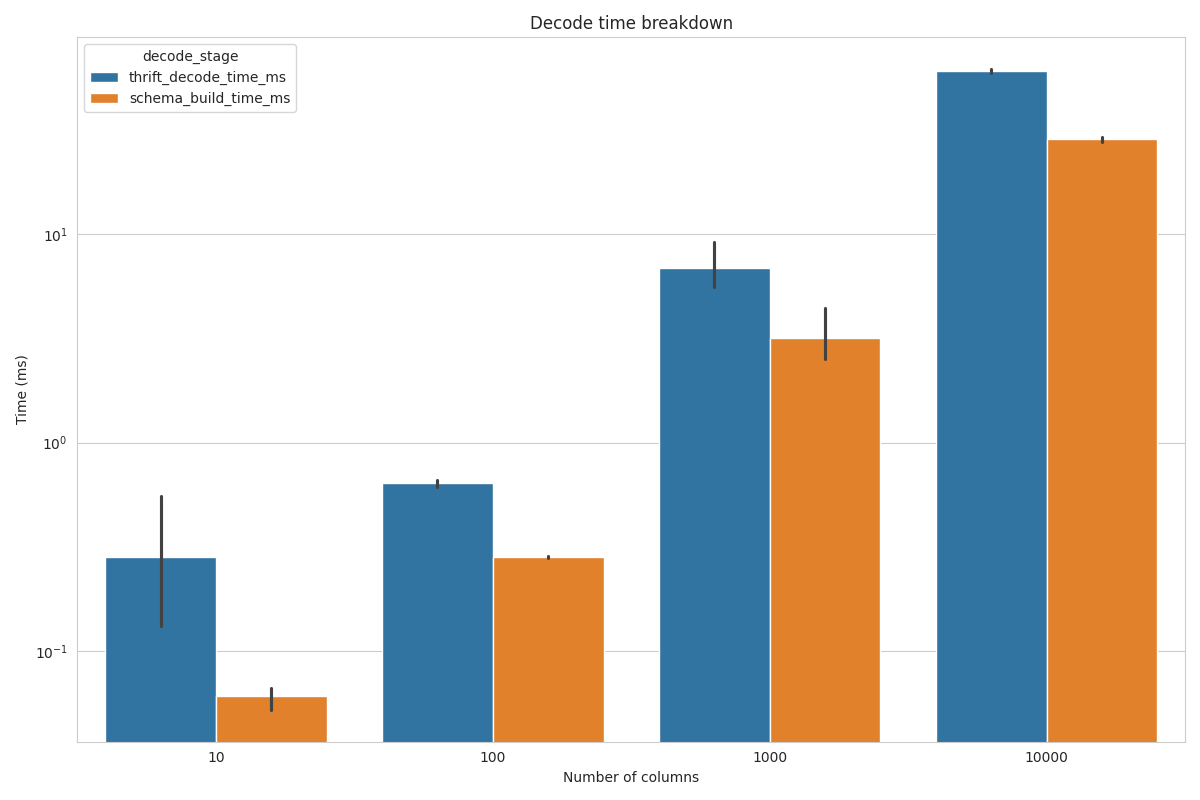

In [18]:
# Plot 2: Decode time breakdown
plt.figure(figsize=(12, 8))
df_melt = df.melt(id_vars=['num_columns', 'stats_level'], 
                  value_vars=['thrift_decode_time_ms', 'schema_build_time_ms'],
                  var_name='decode_stage', value_name='time_ms')
sns.barplot(x='num_columns', y='time_ms', hue='decode_stage', data=df_melt)
plt.xlabel('Number of columns')
plt.ylabel('Time (ms)')
plt.title('Decode time breakdown')
plt.yscale('log')
plt.tight_layout()
plt.savefig('./decode_time_breakdown.png')
plt.close()

Image(filename='./decode_time_breakdown.png')

This plot shows the breakdown of the decode time into Thrift decode time and schema build time for different numbers of columns. It helps us understand the relative contributions of Thrift decoding and schema building to the total decode time.

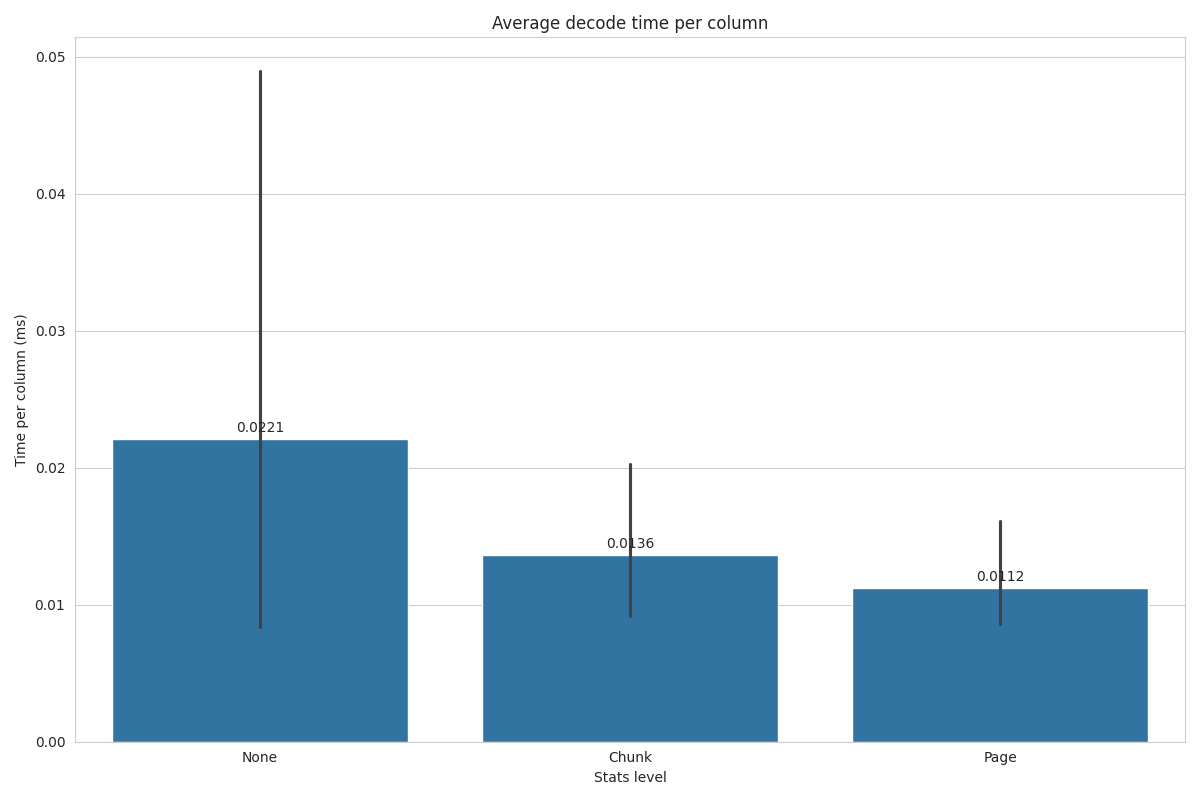

In [19]:
# Plot 3: Decode time per column
plt.figure(figsize=(12, 8))
df['time_per_column_ms'] = df['total_decode_time_ms'] / df['num_columns']
sns.barplot(x='stats_level', y='time_per_column_ms', data=df)
plt.xlabel('Stats level')
plt.ylabel('Time per column (ms)')
plt.title('Average decode time per column')
for i, bar in enumerate(plt.gca().patches):
    plt.annotate(f'{bar.get_height():.4f}', 
                 (bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', xytext=(0, 3),
                 textcoords='offset points')
plt.tight_layout()
plt.savefig('./decode_time_per_column.png')
plt.close()

Image(filename='./decode_time_per_column.png')

This plot displays the average decode time per column for different statistics levels. It helps us understand how the decode time scales with the number of columns and how different statistics levels impact the decode time per column.

### Statistics

In this benchmark, we focus on analyzing the impact of statistics on the performance of Parquet files. We measure the file size, total statistics decode time, and decode time per column for files with statistics enabled and disabled.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv('benchmark_stats.csv')

# Convert microseconds to milliseconds
df['stats_decode_time_ms'] = df['stats_decode_time_us'] / 1000

# Convert bytes to megabytes
df['size_mb'] = df['size_bytes'] / (1024 * 1024)

df

,num_columns,num_row_groups,stats_decode_time_us,size_bytes,stats_enabled,stats_decode_time_ms,size_mb
0,10,1,137.097,577133,False,0.137097,0.550397
1,10,1,289.342,577869,True,0.289342,0.551099
2,10,1,265.909,577893,True,0.265909,0.551122
3,100,1,901.060,5770709,False,0.901060,5.503377
4,100,1,1958.820,5778921,True,1.958820,5.511209
5,100,1,1947.590,5778953,True,1.947590,5.511239
6,1000,1,7330.320,57711168,False,7.330320,55.037659
7,1000,1,30962.100,57793324,True,30.962100,55.116009
8,1000,1,19548.200,57793240,True,19.548200,55.115929
9,10000,1,76965.800,577187531,False,76.965800,550.448924


In [21]:
# Set up the plot style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 20

# Define colors for Stats Enabled and Disabled
color_enabled = '#ff7f0e'  # Orange
color_disabled = '#1f77b4'  # Blue
palette = {True: color_enabled, False: color_disabled}

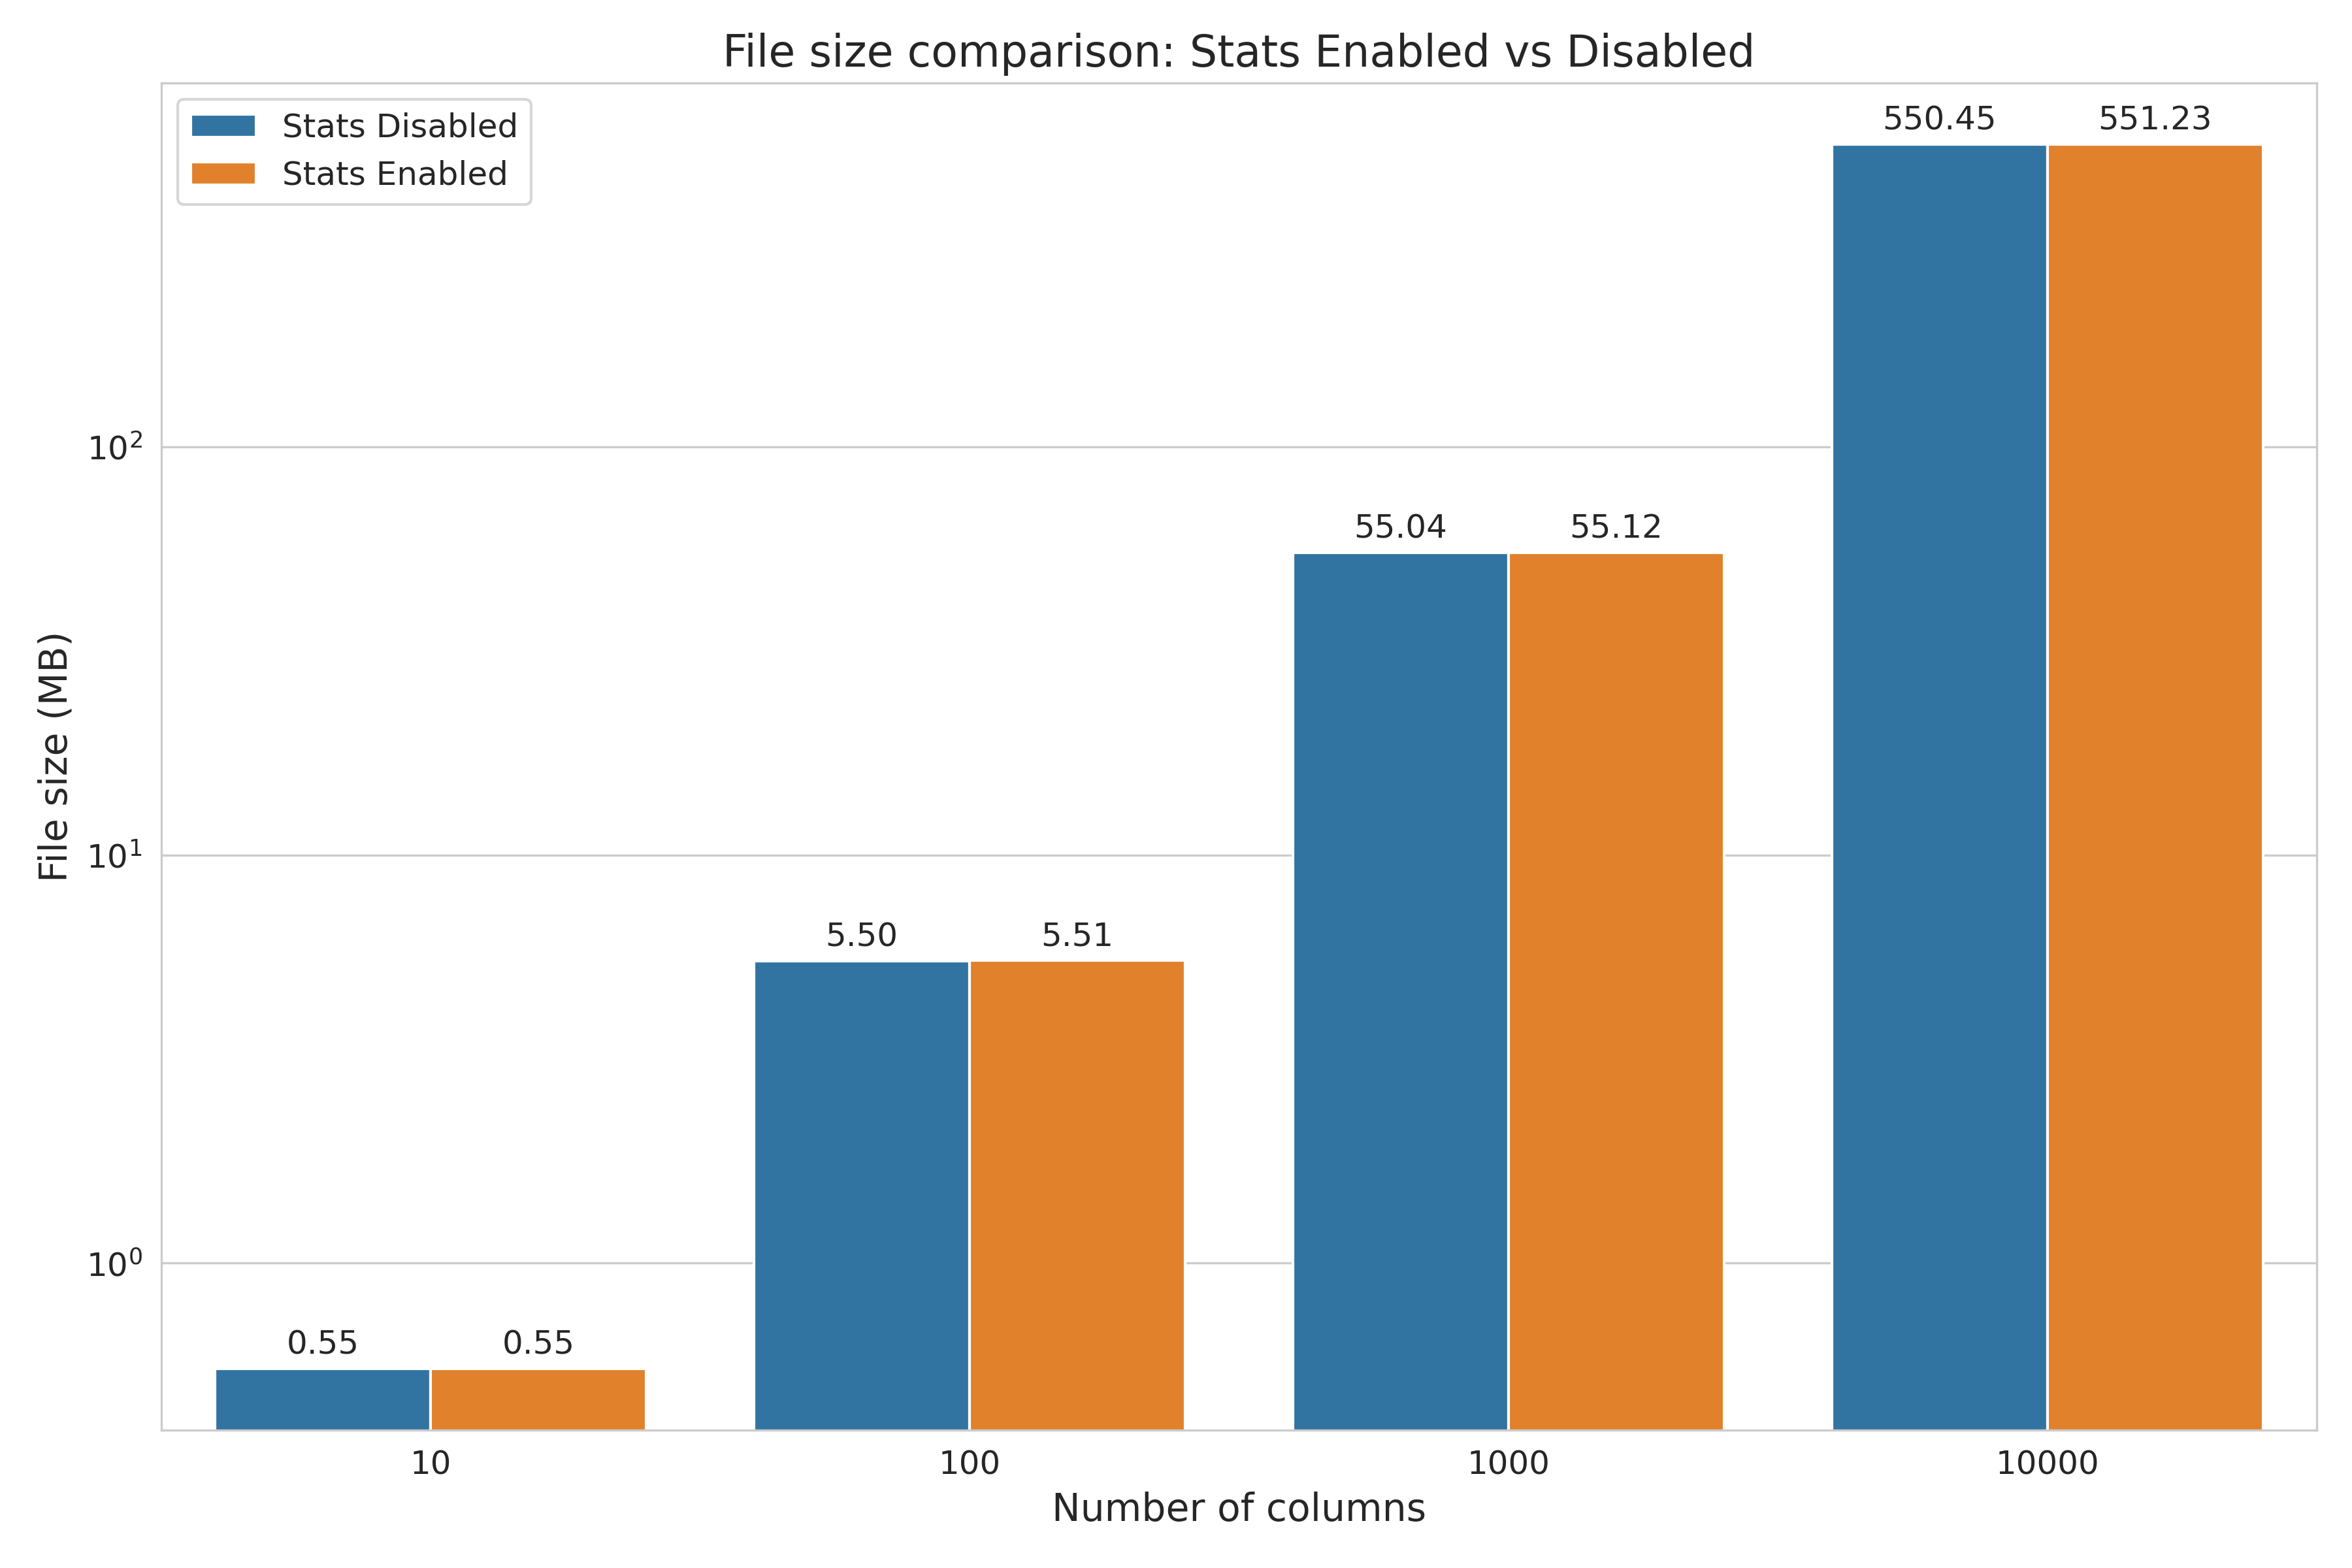

In [22]:
# Plot 1: File size comparison
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='num_columns', y='size_mb', hue='stats_enabled', data=df, palette=palette)
plt.xlabel('Number of columns')
plt.ylabel('File size (MB)')
plt.title('File size comparison: Stats Enabled vs Disabled')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Stats Disabled', 'Stats Enabled'])
plt.yscale('log')  # Use log scale for y-axis
for i, bar in enumerate(plt.gca().patches):
    plt.annotate(f'{bar.get_height():.2f}', 
                 (bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', xytext=(0, 3),
                 textcoords='offset points')
plt.tight_layout()
plt.savefig('./stats_file_size_comparison_log.png', dpi=300)
plt.close()

Image(filename='./stats_file_size_comparison_log.png')

This plot compares the file sizes for Parquet files with statistics enabled and disabled. It helps us understand the impact of statistics on the file size and how it varies with the number of columns.

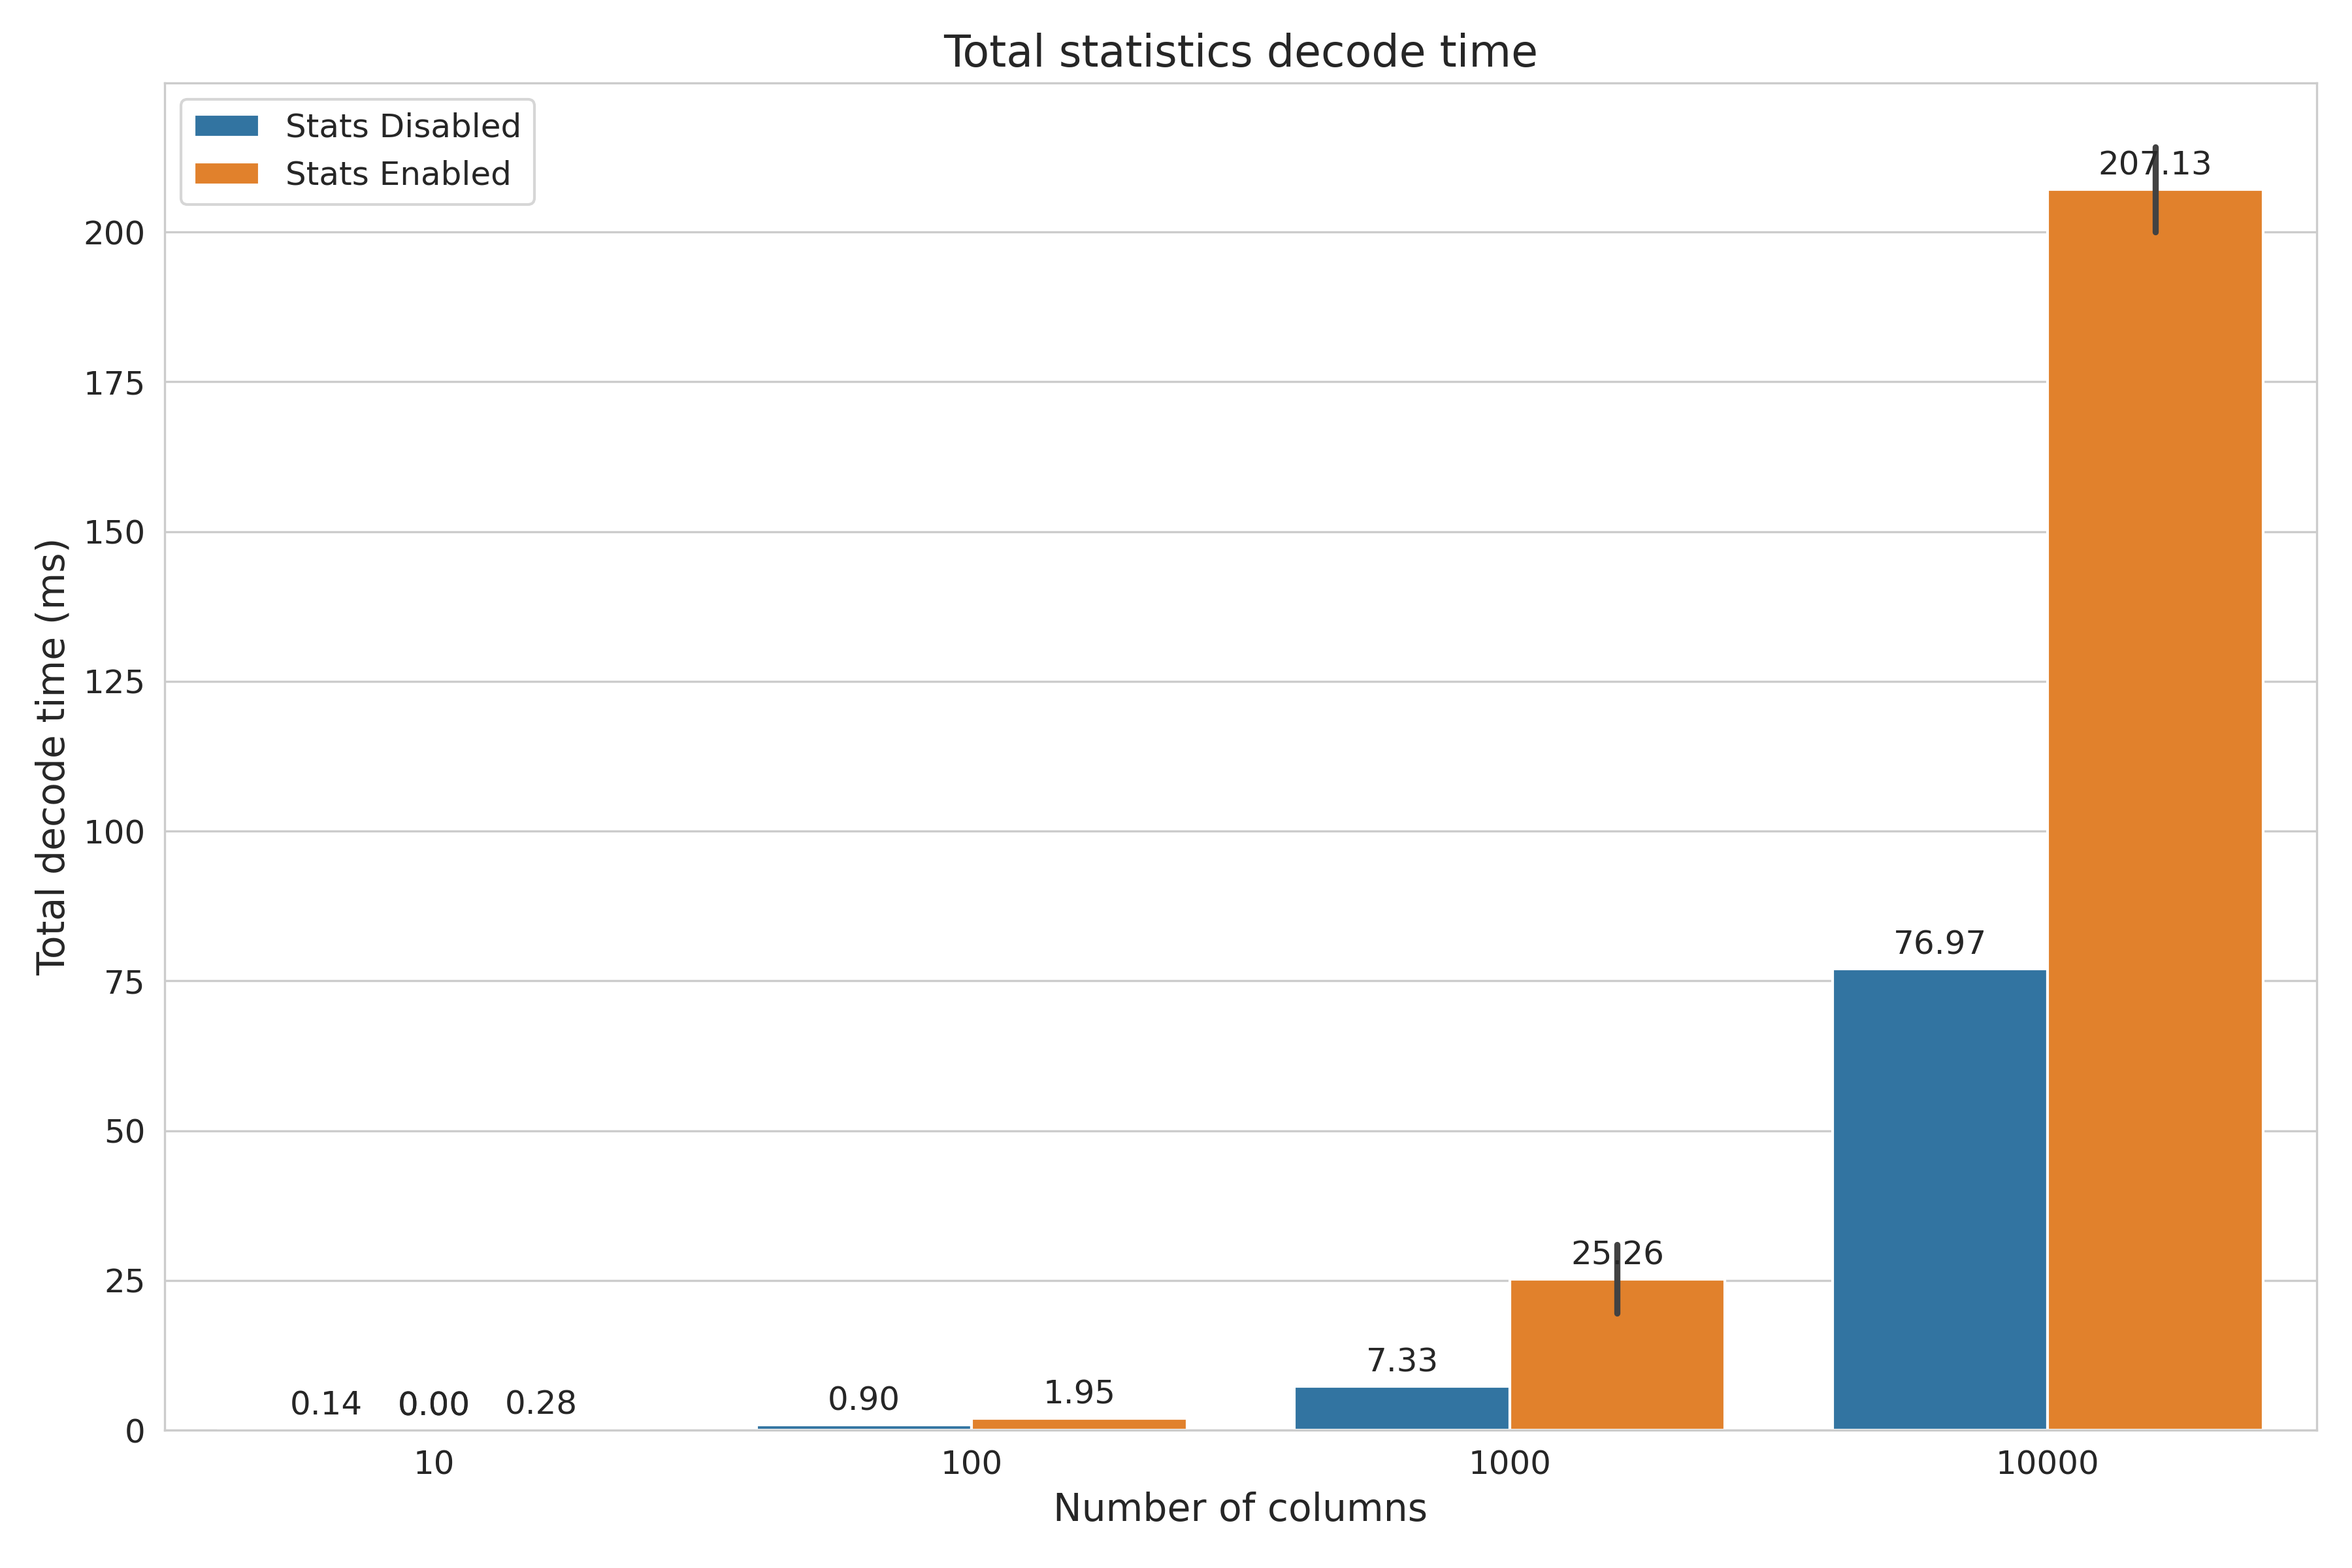

In [23]:
# Plot 2: Total statistics decode time
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='num_columns', y='stats_decode_time_ms', hue='stats_enabled', data=df, palette=palette)
plt.xlabel('Number of columns')
plt.ylabel('Total decode time (ms)')
plt.title('Total statistics decode time')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Stats Disabled', 'Stats Enabled'])
for i, bar in enumerate(plt.gca().patches):
    plt.annotate(f'{bar.get_height():.2f}', 
                 (bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', xytext=(0, 3),
                 textcoords='offset points')
plt.tight_layout()
plt.savefig('./stats_total_decode_time.png', dpi=300)
plt.close()

Image(filename='./stats_total_decode_time.png')

This plot shows the total statistics decode time for Parquet files with statistics enabled and disabled. It helps us understand the additional time required to decode statistics when they are present in the file.

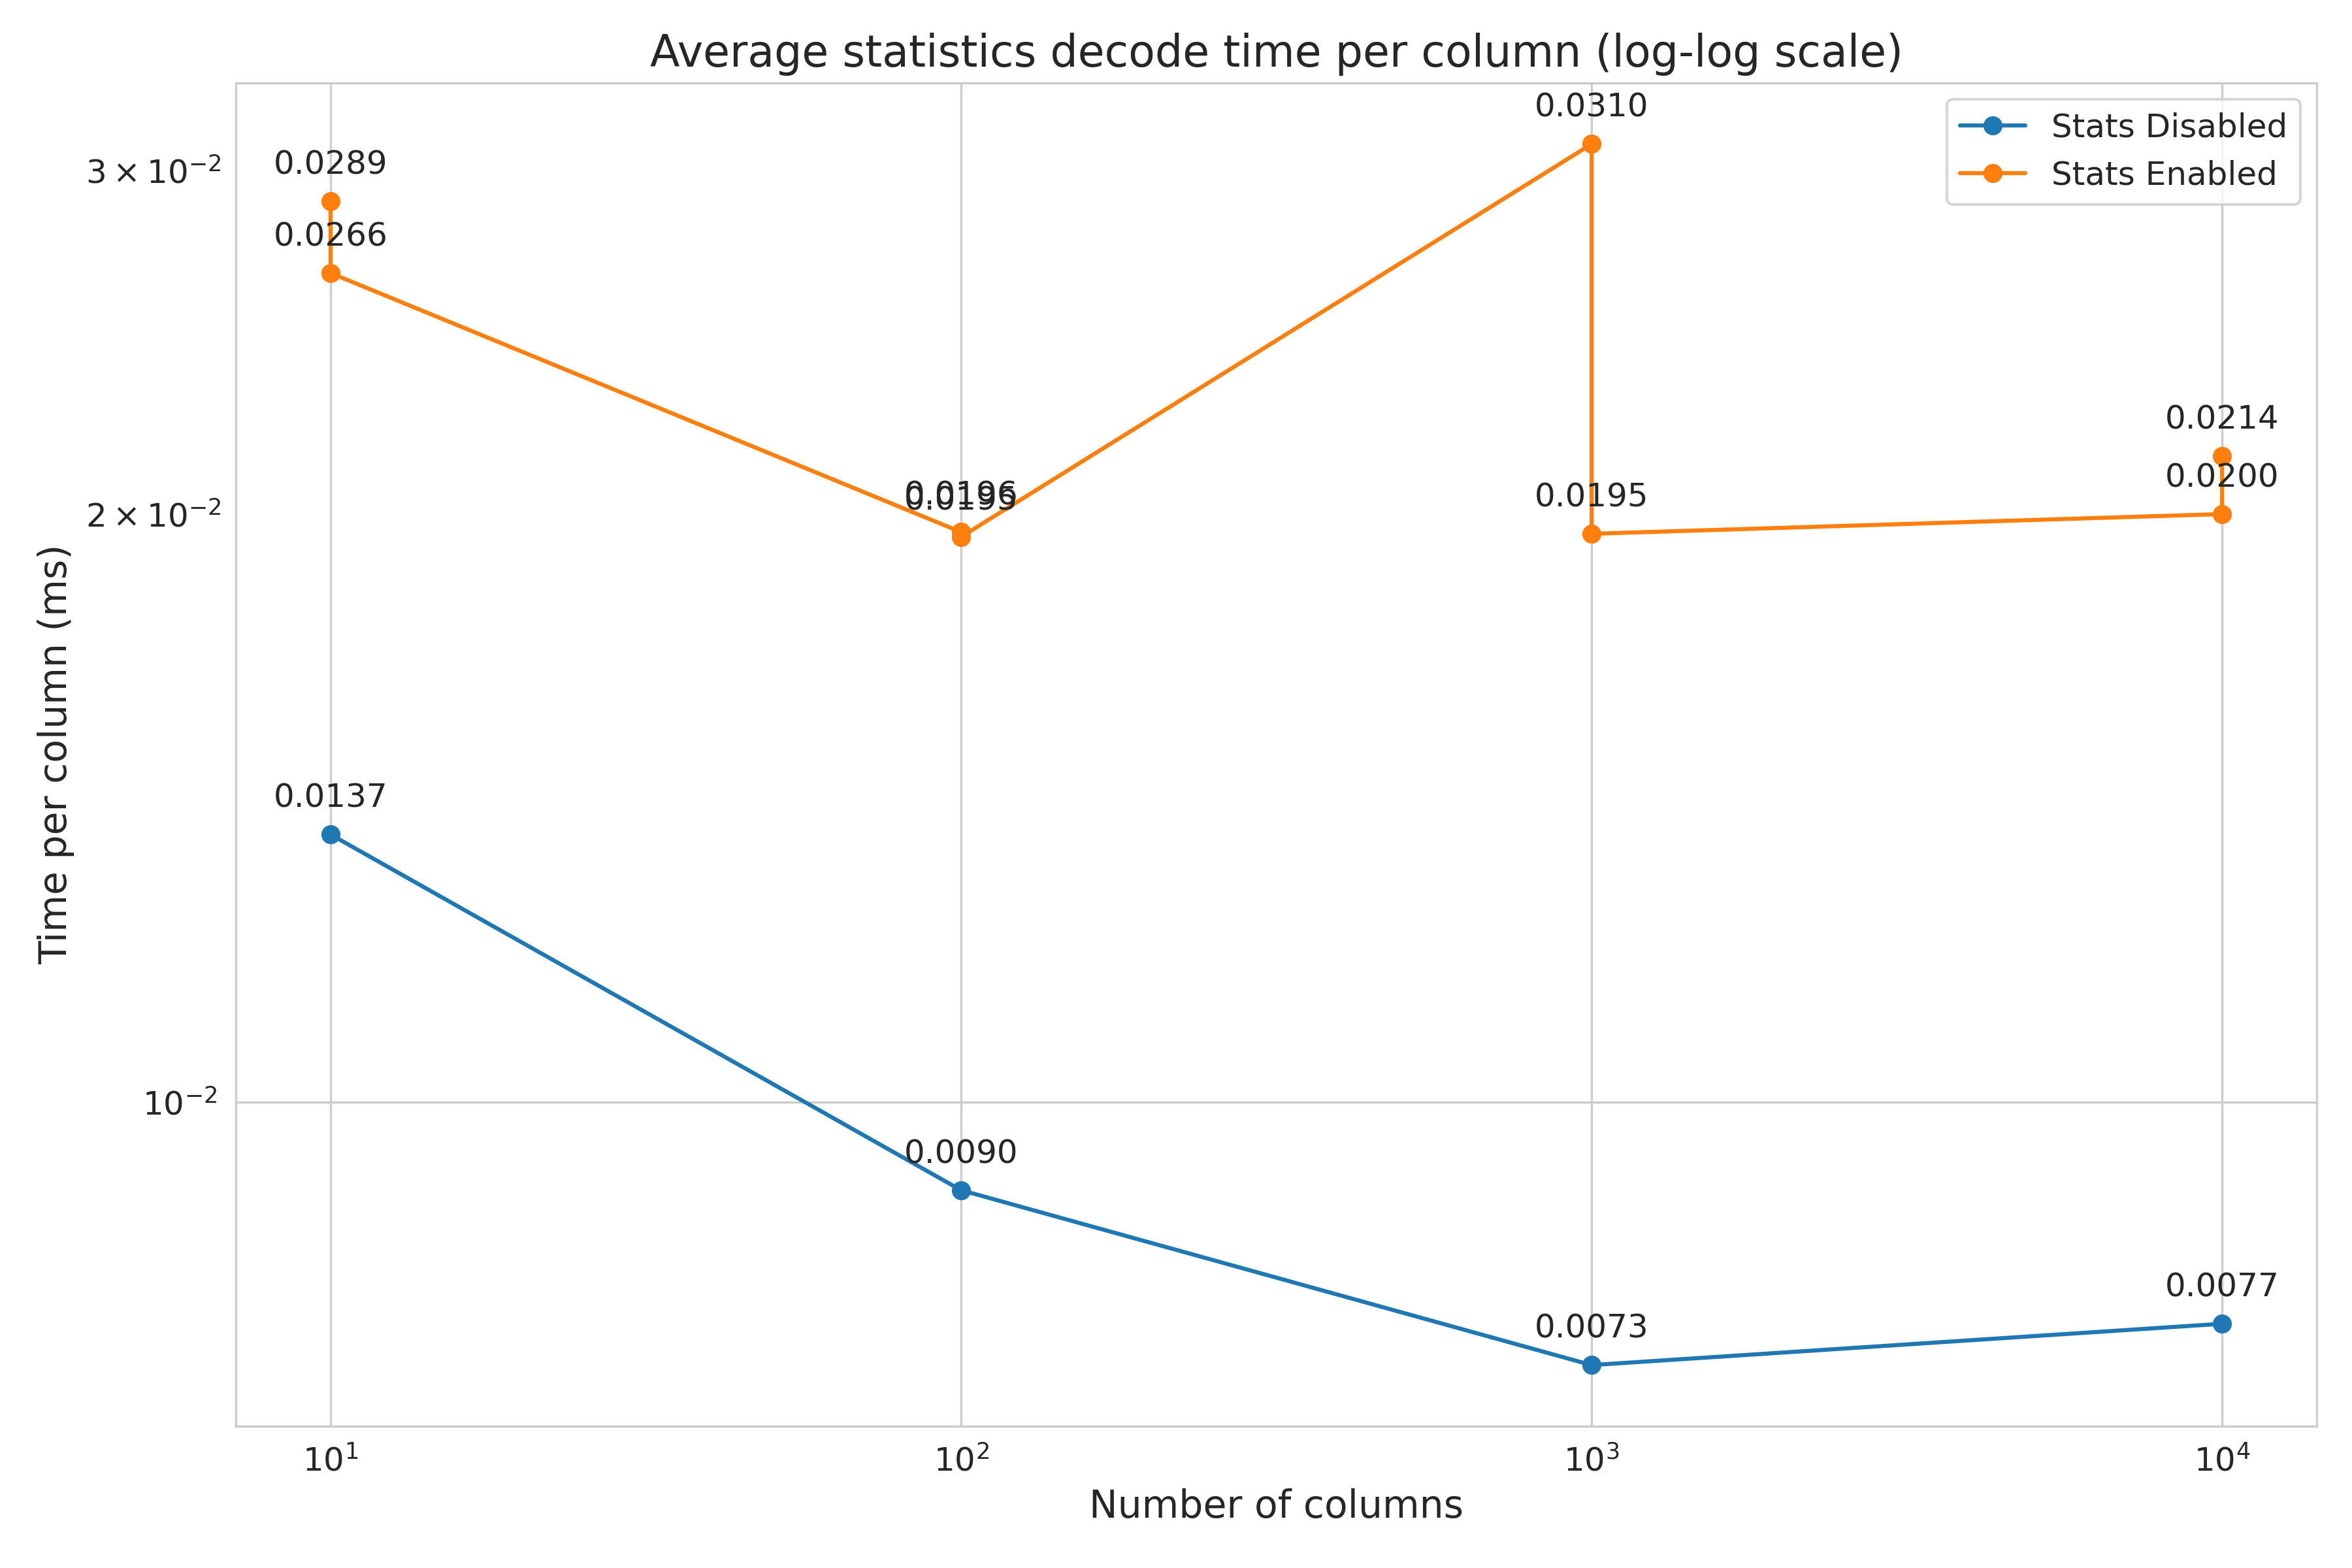

In [24]:
# Plot 3: Decode time per column (log-log scale)
plt.figure(figsize=(12, 8))
df['time_per_column_ms'] = df['stats_decode_time_ms'] / df['num_columns']
handles = []
labels = []
for stats_enabled in df['stats_enabled'].unique():
    data = df[df['stats_enabled'] == stats_enabled]
    color = color_enabled if stats_enabled else color_disabled
    label = 'Stats Enabled' if stats_enabled else 'Stats Disabled'
    line, = plt.plot(data['num_columns'], data['time_per_column_ms'], marker='o', label=label, color=color)
    handles.append(line)
    labels.append(label)
    for _, point in data.iterrows():
        plt.annotate(f"{point['time_per_column_ms']:.4f}", 
                     (point['num_columns'], point['time_per_column_ms']),
                     textcoords="offset points", xytext=(0,10), ha='center')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of columns')
plt.ylabel('Time per column (ms)')
plt.title('Average statistics decode time per column (log-log scale)')
plt.legend(handles=handles, labels=labels)
plt.tight_layout()
plt.savefig('./stats_decode_time_per_column_log.png', dpi=300)
plt.close()

Image(filename='./stats_decode_time_per_column_log.png')

This plot displays the average statistics decode time per column on a log-log scale. It helps us understand how the decode time per column scales with the number of columns and how the presence of statistics affects the decode time per column.

## Compression Algorithms

The following benchmarks provide valuable insights into the performance characteristics of different compression algorithms in terms of encoding time, decoding time, and compressed size. They help us make informed decisions when selecting compression algorithms based on the specific requirements of our dataset and the trade-offs between compression ratio and processing time.

In [11]:
import os
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Compile and run the C++ benchmark program
os.system("../build/compression_benchmark")

Running benchmark for 10 columns...
Running benchmark for 100 columns...
Running benchmark for 1000 columns...
All benchmarks completed successfully. Results saved to CSV files.


0

In [12]:
# Read all CSV files
csv_files = glob.glob('compression_benchmark_*_compression_benchmark.csv')
dfs = [pd.read_csv(f) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

# Map algorithm numbers to names
algo_map = {0: 'Uncompressed', 1: 'Snappy', 2: 'Gzip', 3: 'Brotli', 4: 'Zstd'}
df['algorithm'] = df['algorithm'].map(algo_map)

df

,algorithm,num_columns,num_rows,encoding_time_ms,decoding_time_ms,compressed_size_mb
0,Uncompressed,10,10000,42.4480,6.50225,0.551133
1,Snappy,10,10000,29.6854,3.72805,0.551232
2,Gzip,10,10000,41.9951,5.62163,0.515518
3,Brotli,10,10000,70.1207,17.08110,0.499020
4,Zstd,10,10000,44.0030,4.92602,0.514209
5,Uncompressed,1000,10000,2824.8500,359.80500,55.115300
6,Snappy,1000,10000,2859.3000,371.26800,55.127400
7,Gzip,1000,10000,4381.1400,514.77000,51.538400
8,Brotli,1000,10000,5710.3300,1564.54000,49.908700
9,Zstd,1000,10000,4190.5000,433.88900,51.456500


In [13]:
# Set up the plot style
sns.set_style("whitegrid")

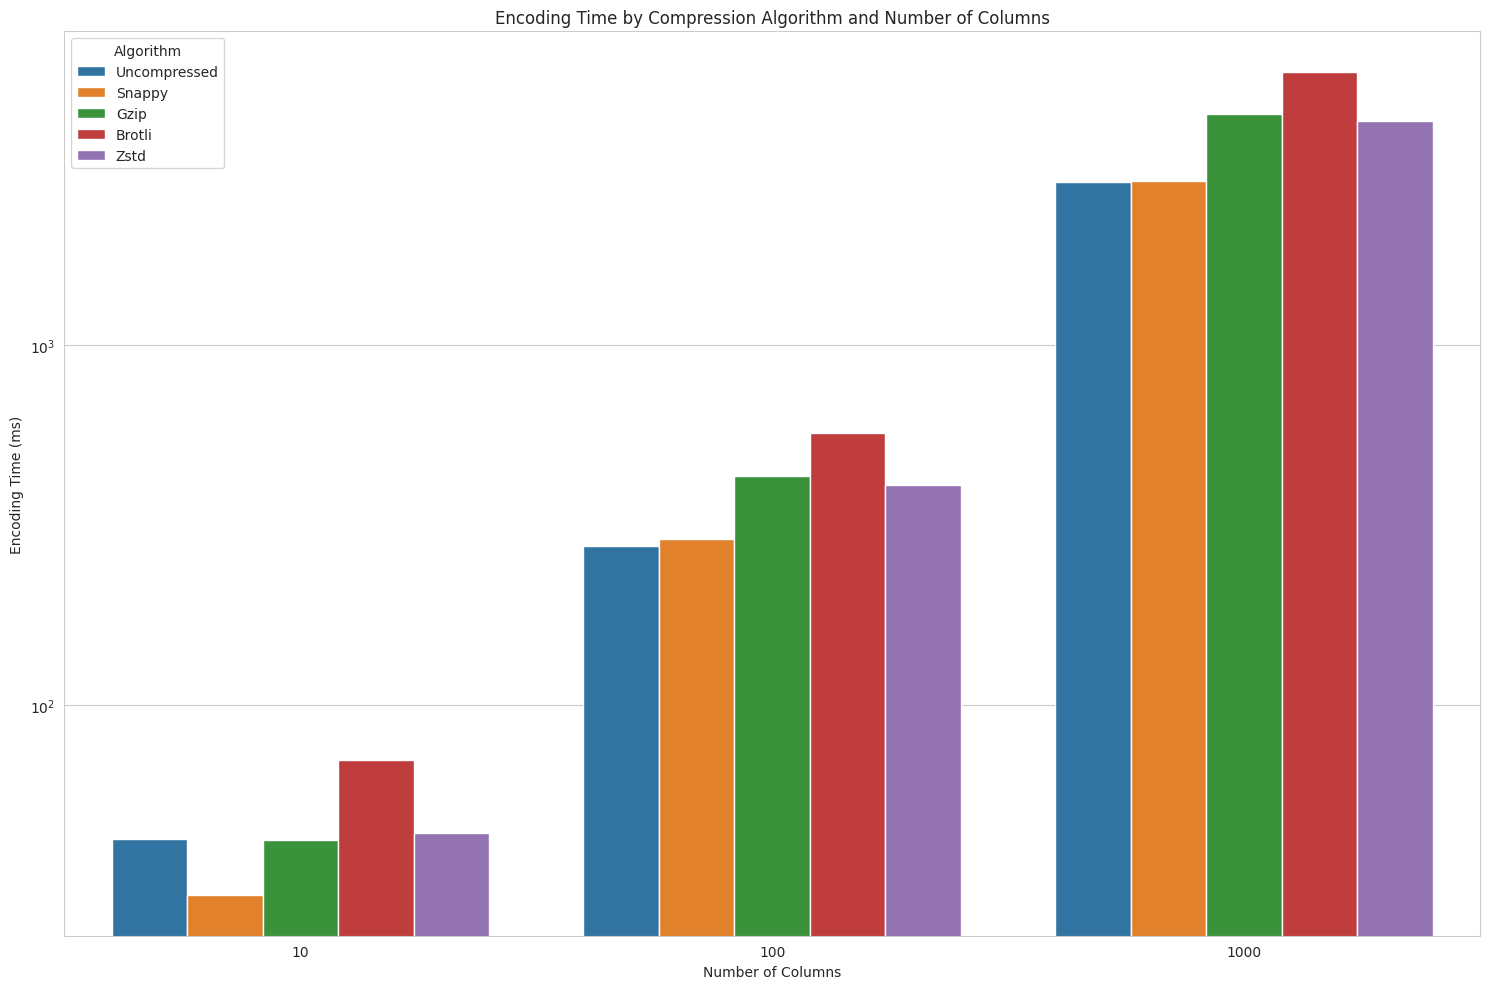

In [14]:
# Plot 1: Encoding time
plt.figure(figsize=(15, 10))
sns.barplot(x='num_columns', y='encoding_time_ms', hue='algorithm', data=df)
plt.title('Encoding Time by Compression Algorithm and Number of Columns')
plt.ylabel('Encoding Time (ms)')
plt.xlabel('Number of Columns')
plt.yscale('log')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.savefig('./encoding_time.png')
plt.show()
plt.close()

The plot visualizes the encoding time for different compression algorithms and varying numbers of columns. It shows the encoding time in milliseconds on the y-axis and the number of columns on the x-axis. The hue parameter is used to distinguish between different compression algorithms.


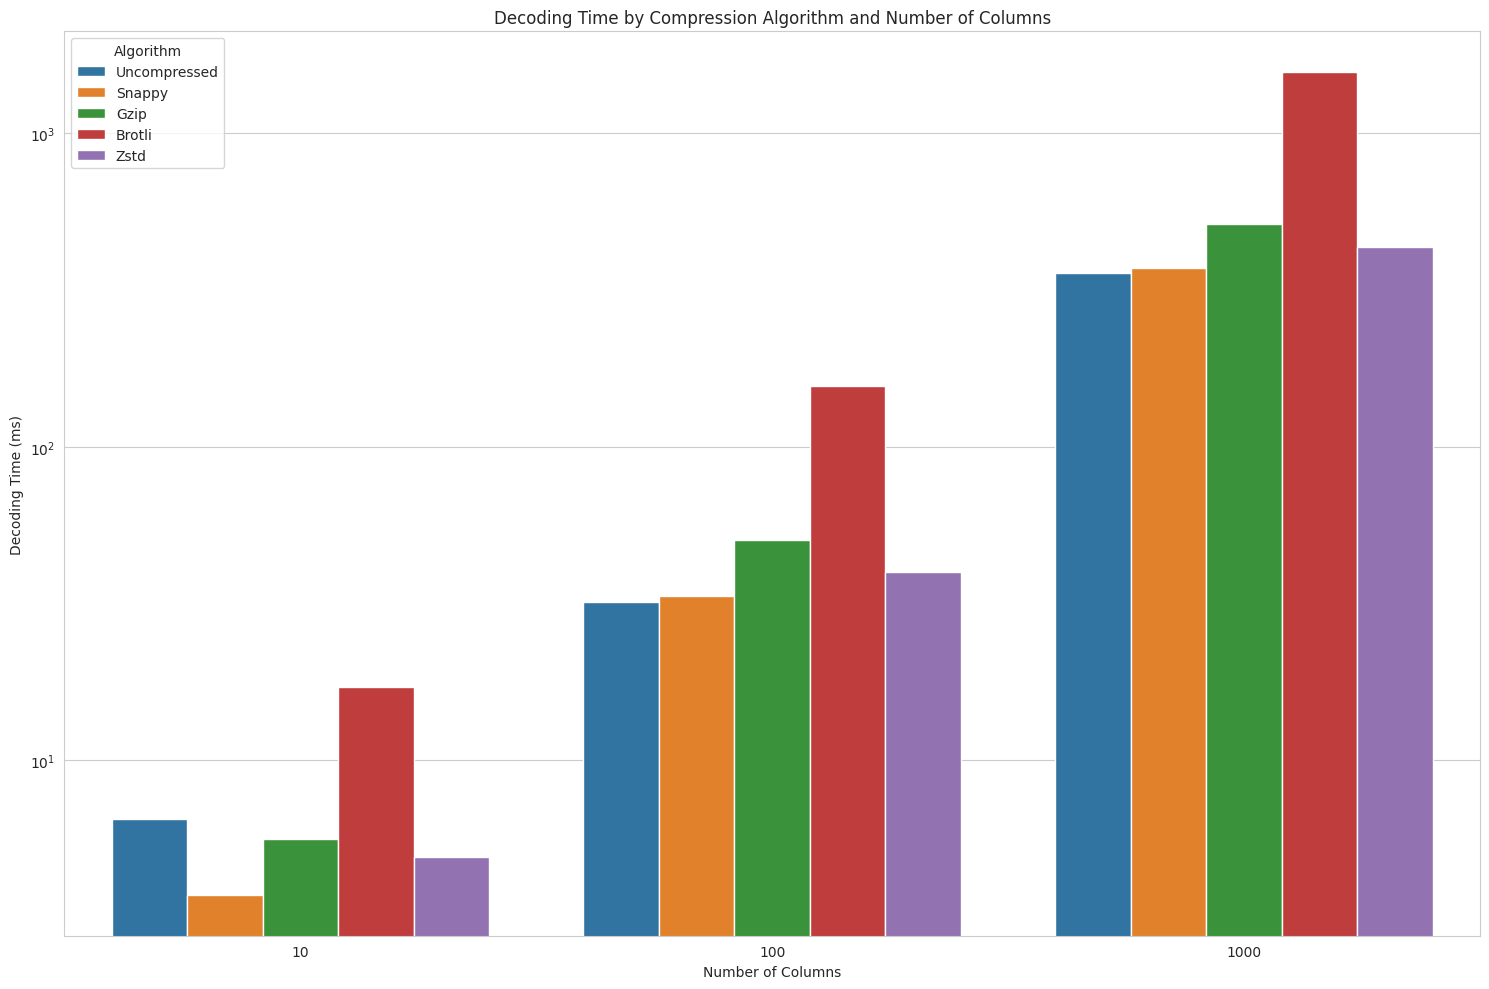

In [15]:
# Plot 2: Decoding time
plt.figure(figsize=(15, 10))
sns.barplot(x='num_columns', y='decoding_time_ms', hue='algorithm', data=df)
plt.title('Decoding Time by Compression Algorithm and Number of Columns')
plt.ylabel('Decoding Time (ms)')
plt.xlabel('Number of Columns')
plt.yscale('log')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.savefig('./decoding_time.png')
plt.show()
plt.close()

This plot provides insights into how the decoding time changes across different compression algorithms and how it is influenced by the number of columns in the dataset. The logarithmic scale on the y-axis allows for a clear comparison of decoding times across a wide range of values.

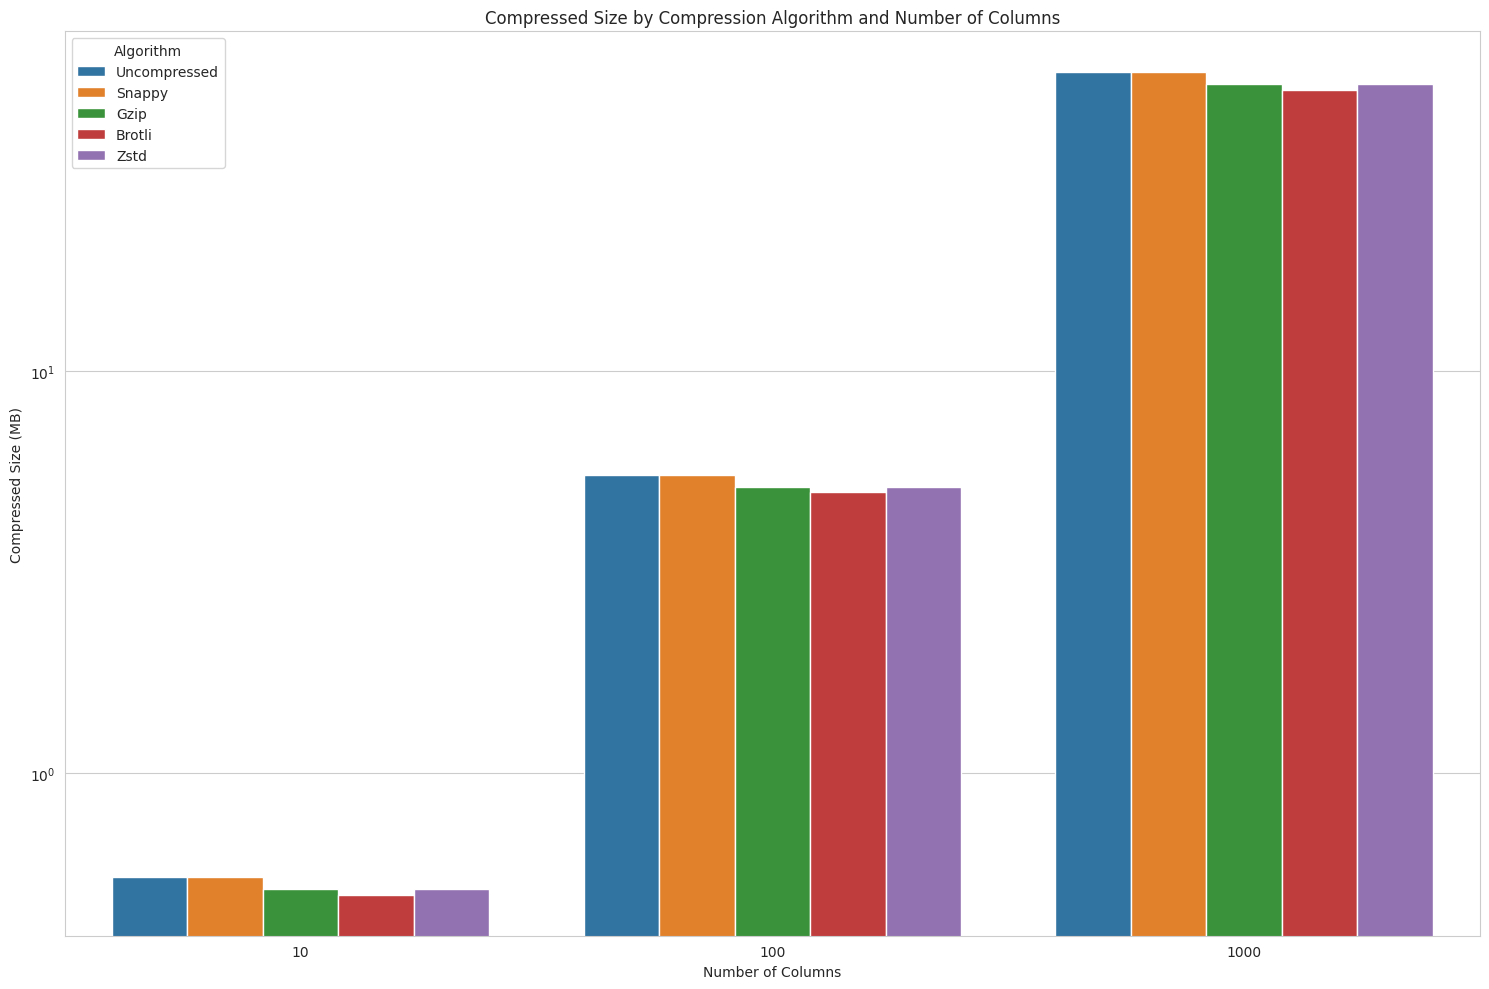

In [16]:
# Plot 3: Compressed size
plt.figure(figsize=(15, 10))
sns.barplot(x='num_columns', y='compressed_size_mb', hue='algorithm', data=df)
plt.title('Compressed Size by Compression Algorithm and Number of Columns')
plt.ylabel('Compressed Size (MB)')
plt.xlabel('Number of Columns')
plt.yscale('log')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.savefig('./compressed_size.png')
plt.show()
plt.close()

This plot helps us understand how the compressed size varies across different compression algorithms and how it is affected by the number of columns in the dataset. By using a logarithmic scale for the y-axis, it allows us to compare the compressed sizes across a wide range of values.

## References

Major ideas were drawn from discussions by the community on [Parquet Metadata evolution](https://docs.google.com/document/d/1PQpY418LkIDHMFYCY8ne_G-CFpThK15LLpzWYbc7rFU/edit).

The inspiration for this came from the article: [How Good is Parquet for Wide Tables Really?](https://www.influxdata.com/blog/how-good-parquet-wide-tables)